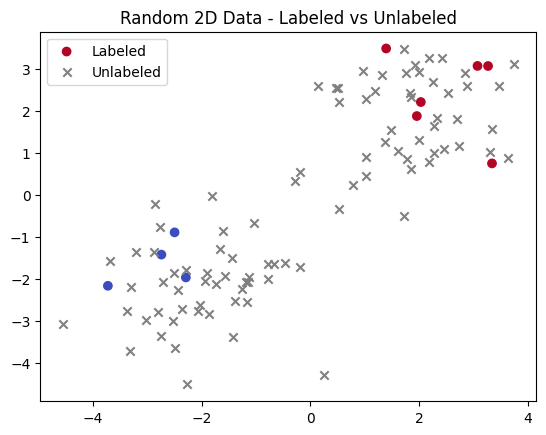

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Toplam veri sayısı ve etiketli örnek sayısı
N = 100  # toplam nokta sayısı
l = 10   # etiketli örnek sayısı
u = N - l

# 2D noktaları üret (örnek olarak 2 sınıfa dağılmış)
class_1 = np.random.randn(N//2, 2) + np.array([2, 2])
class_2 = np.random.randn(N//2, 2) + np.array([-2, -2])
X = np.vstack((class_1, class_2))

# Etiketleri oluştur
y_true = np.array([1] * (N//2) + [-1] * (N//2))

# Karıştır
idx = np.random.permutation(N)
X = X[idx]
y_true = y_true[idx]

# l örneğe etiket ver
labeled_indices = np.random.choice(N, l, replace=False)
unlabeled_indices = np.setdiff1d(np.arange(N), labeled_indices)

# Etiketli ve etiketsiz y dizisi
y_labeled = np.full(N, np.nan)
y_labeled[labeled_indices] = y_true[labeled_indices]

# Görselleştir
plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y_labeled[labeled_indices], cmap='coolwarm', marker='o', label="Labeled")
plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], color='gray', marker='x', label="Unlabeled")
plt.legend()
plt.title("Random 2D Data - Labeled vs Unlabeled")
plt.show()


In [2]:
def rbf_similarity(x1, x2, sigma=1.0):
    dist_sq = np.sum((x1 - x2) ** 2)
    return np.exp(-dist_sq / (sigma ** 2))

# Ağırlık matrisleri
W = np.zeros((len(labeled_indices), len(unlabeled_indices)))  # w_ij
W_tilde = np.zeros((len(unlabeled_indices), len(unlabeled_indices)))  # w̃_ij

sigma = 1.0  # isteğe göre ayarlanabilir

# w_ij: labeled vs unlabeled
for i, li in enumerate(labeled_indices):
    for j, uj in enumerate(unlabeled_indices):
        W[i, j] = rbf_similarity(X[li], X[uj], sigma=sigma)

# w̃_ij: unlabeled vs unlabeled
for i, ui in enumerate(unlabeled_indices):
    for j, uj in enumerate(unlabeled_indices):
        if i != j:  # kendine benzerlik gereksiz
            W_tilde[i, j] = rbf_similarity(X[ui], X[uj], sigma=sigma)


In [3]:
# Başlangıç tahmini (rastgele)
y_unlabeled = np.random.randn(len(unlabeled_indices))

# Etiketli y'ler
y_l = y_true[labeled_indices]

# Gradient Descent parametreleri
lr = 0.01
max_iter = 1000

for epoch in range(max_iter):
    grad = np.zeros_like(y_unlabeled)

    # İlk terim: labeled-unlabeled benzerlik
    for j, uj in enumerate(unlabeled_indices):
        for i, li in enumerate(labeled_indices):
            grad[j] += 2 * W[i, j] * (y_unlabeled[j] - y_l[i])
    
    # İkinci terim: unlabeled-unlabeled benzerlik
    for j in range(len(unlabeled_indices)):
        for i in range(len(unlabeled_indices)):
            if i != j:
                grad[j] += 2 * W_tilde[i, j] * (y_unlabeled[j] - y_unlabeled[i])
    
    # Güncelleme
    y_unlabeled -= lr * grad

# Tahmin edilen etiketler
y_pred = np.sign(y_unlabeled)


Unlabeled accuracy: 0.99


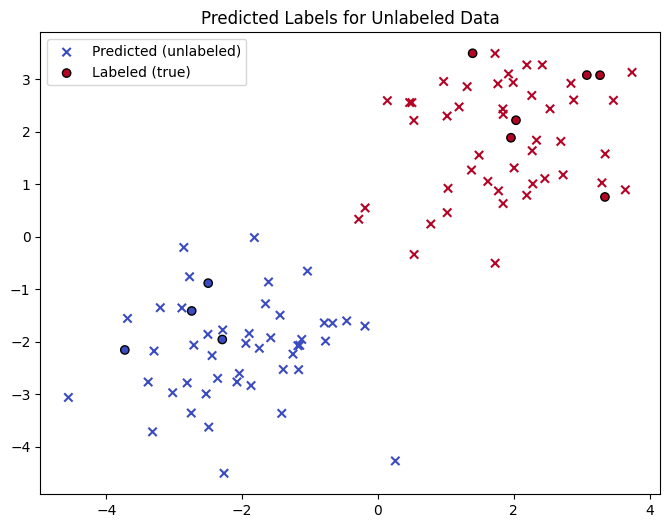

In [4]:
from sklearn.metrics import accuracy_score

# Doğruluk (accuracy)
accuracy = accuracy_score(y_true[unlabeled_indices], y_pred)
print(f"Unlabeled accuracy: {accuracy:.2f}")

# Görselleştir
plt.figure(figsize=(8, 6))
plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], c=y_pred, cmap='coolwarm', marker='x', label="Predicted (unlabeled)")
plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y_true[labeled_indices], cmap='coolwarm', marker='o', edgecolor='k', label="Labeled (true)")
plt.legend()
plt.title("Predicted Labels for Unlabeled Data")
plt.show()
